# Python notebook demonstrating streaming OnlineGCP applied to Chicago Crime data
Demonstrates results similar to those found in the paper Eric T. Phipps, Nicholas T. Johnson, and Tamara G. Kolda. 2023. 
Streaming Generalized Canonical Polyadic Tensor Decompositions. In Proceedings of the Platform for Advanced Scientific Computing Conference (PASC '23).
[https://doi.org/10.1145/3592979.3593405](https://dl.acm.org/doi/10.1145/3592979.3593405).

It requires downloading the Chicago Crime data, which can be obtained from [FROSTT](http://frostt.io/tensors/chicago-crime/).

Note that because of the large number of time slices in the data, this takes a while to run (> 1 hour) on most platforms.

### Import needed modules
Generally better performance is obtained on CPU architectures with OpenMP parallelism when pygenten is imported before pyttb/numpy.

In [1]:
import pygenten as gt
import pyttb as ttb
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import copy as cpy
import pandas as pd
import seaborn as sns

### Read and preprocess the data

In [2]:
fname = 'chicago-crime-comm.tns'   # Data file from FROSTT
start_time = 500                   # Number of time steps to drop (early times have very little volume)
num_warm = 10                      # Number of time steps in the warm start
rank = 50                          # Rank of the CP decompositions

# read data (we use this approach because it doesn't require a header in the file, whereas ttb.import_data() does, and the file comes from FROSTT without a header)
X = gt.make_ttb_sptensor(gt.import_sptensor(fname,index_base=1)) 
print(X)
X = X.permute(np.array((1,2,3,0))) # reorder modes to move time mode to the last as required by the streaming algorithm
#X = sort_tensor(X)                 # sort tensor along time mode (mode 3)
X = X[:,:,:,start_time:]           # drop early slices due to low volume
#X = X.elemfun(lambda vals: np.ones(vals.shape)) # replace nonzero values with 1s for binary
#X0 = X[:,:,:,0:num_warm]           # data for warm-start
#slices = split_tensor(X)           # partition data into slices, making sure to keep an explicit time mode as required by streaming algorithm


Are you sure you want to print all nonzeros? (Y/N) N


sparse tensor of shape (6186, 24, 77, 32) with 5330673 nonzeros



### Compute static gcp decomposition

In [3]:
gcp_params = dict()
gcp_params['type'] = 'poisson'
gcp_params['sampling'] = 'semi-stratified'
gcp_params['fnzs'] = 100000
gcp_params['fzs'] = 100000
gcp_params['gnzs'] = 10000
gcp_params['gzs'] = 10000
gcp_params['hash'] = True
gcp_params['fuse'] = True
gcp_params['maxiters'] = 100
gcp_params['fails'] = 2
u_static_gcp,_,_ = gt.gcp_sgd(X,rank=rank,**gcp_params)
u_static_gcp.arrange() # Arange
#reconstruction_static_gcp = binary_reconstruction_error(u_static_gcp,slices)


Sparse tensor: 
  24 x 77 x 32 x 5686 (3.36247e+08 total entries)
  5288704 (1.6%) Nonzeros and 330958592 (98.4%) Zeros
  2.7e+03 Frobenius norm

Execution environment:
  MPI grid: 1 x 1 x 1 x 1 processes (1 total)
  Execution space: serial

GCP-SGD (Generalized CP Tensor Decomposition):
Generalized function type: Poisson (count)
Optimization method: adam
Max iterations (epochs): 100
Iterations per epoch: 1000
Traditional annealer, learning rate: 1.0e-03, decay: 1.0e-01
  Function sampler:  stratified with 100000 nonzero and 100000 zero samples
  Gradient sampler:  semi-stratified with 10000 nonzero and 10000 zero samples
  Gradient nonzero samples per epoch: 10000000 (189.1%)
Gradient method: Fused sampling and single MTTKRP

Hashing tensor for faster sampling...-1.0 seconds
Initial f-est:  6.020012e+07, tensor norm:  2.721e+03
Epoch   1: f-est =  2.110400e+07, step =  1.0e-03, time = -1.00e+00 sec
Epoch   2: f-est =  2.060326e+07, step =  1.0e-03, time = -1.00e+00 sec
Epoch   3: f-e

In [4]:
u_static_gcp_extracted = u_static_gcp.extract([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  #[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
#u_static_gcp_extracted
#print(np.array(u_static_gcp_extracted))

In [5]:
u_static_gcp_hours = u_static_gcp_extracted.factor_matrices[0]
u_static_gcp_hours = np.array(u_static_gcp_hours)           #[:10, 0]
#print("u_static_gcp_hours: ", u_static_gcp_hours)

u_static_gcp_neighborhood = u_static_gcp_extracted.factor_matrices[1]
u_static_gcp_neighborhood = np.array(u_static_gcp_neighborhood)             #[:10, 1]
#print("u_static_gcp_neighborhood:", u_static_gcp_neighborhood)

u_static_gcp_crime_type = u_static_gcp_extracted.factor_matrices[2]
u_static_gcp_crime_type = np.array(u_static_gcp_crime_type)            #[:10, 1]
#print("u_static_gcp_crime_type:", u_static_gcp_crime_type)

u_static_gcp_day = u_static_gcp_extracted.factor_matrices[3]
u_static_gcp_day = np.array(u_static_gcp_day)               #[:10, 3]
#print("u_static_gcp_day:", u_static_gcp_day)

In [6]:
# Read the .map file and return an array containing the content of the file
def read_map_file_to_array(file_path):
    with open(file_path, 'r') as file:
        # Read all lines and strip whitespace
        lines = [line.split('-')[0].strip() for line in file.readlines()]
        indices = [0]
        year = [lines[0]]
       
        for i in range(1,len(lines)):
           if year[-1] != lines[i]:
               year.append(lines[i])
               indices.append(i)
               
    return indices, year

# Example with mode-1
indices_content, year_content = read_map_file_to_array('mode-1-date.map')
print(indices_content)
print(year_content)



[0, 362, 727, 1092, 1458, 1823, 2188, 2553, 2919, 3284, 3649, 4014, 4380, 4745, 5110, 5475, 5841]
['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']


In [7]:
# Read the .map file and return an array containing the content of the file
def read_map_crimetype_to_array(file_path):
    with open(file_path, 'r') as file:
        # Read all lines and strip whitespace
        lines = [line.strip() for line in file.readlines()]
    return lines, crimes

# Example with mode-4
map_content, crimes = read_map_file_to_array('mode-4-crimetype.map')
print(map_content)
print(crimes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
['ARSON', 'ASSAULT', 'BATTERY', 'BURGLARY', 'CONCEALED CARRY LICENSE VIOLATION', 'CRIM SEXUAL ASSAULT', 'CRIMINAL DAMAGE', 'CRIMINAL TRESPASS', 'DECEPTIVE PRACTICE', 'GAMBLING', 'HOMICIDE', 'HUMAN TRAFFICKING', 'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION', 'KIDNAPPING', 'LIQUOR LAW VIOLATION', 'MOTOR VEHICLE THEFT', 'NARCOTICS', 'NON', 'OBSCENITY', 'OFFENSE INVOLVING CHILDREN', 'OTHER NARCOTIC VIOLATION', 'OTHER OFFENSE', 'PROSTITUTION', 'PUBLIC INDECENCY', 'PUBLIC PEACE VIOLATION', 'RITUALISM', 'ROBBERY', 'SEX OFFENSE', 'STALKING', 'THEFT', 'WEAPONS VIOLATION']


In [8]:
# Get the indexes of the crimes that will go on the vis() plot
def get_indexes_of_crimes():
    # List of crimes that will go on the vis() plot
    crime_types = ["THEFT", "BATTERY", "CRIMINAL DAMAGE", "NARCOTICS", "OTHER OFFENSE", "ASSAULT", "BURGLARY", "MOTOR VEHICLE THEFT", "ROBBERY", "DECEPTIVE PRACTICE", "CRIMINAL TRESPASS", "WEAPONS VIOLATION", "PROSTITUTION"]
    indexes_content, crimes_content = read_map_file_to_array('mode-4-crimetype.map') # Get the list of indexes and all the 32 crimes returned in separate variables
    list_index = [] # List that will contain the indexes of the crimes to appear in the vis() plot

    # Loop through both crimes_types and crimes_content
    # Get the index from crimes_content of the crimes it has in common with crime_types 
    # Then append it in list_index
    for i in range(len(crime_types)):
        for j in range(len(crimes_content)):
            if crime_types[i] == crimes_content[j]:
                list_index.append(j)

    return list_index

In [9]:
def mode_1_plot(u_static_gcp_hours, ax):
    u_static_hours = u_static_gcp_hours
    ax.bar(list(range(len(u_static_gcp_hours))), u_static_hours, color = 'red' , width = 0.6)
    ax.set_xticks([0, 6, 12, 18, 24], labels=["0", "6", "12", "18", "24"], rotation=90)

def mode_2_plot(u_static_gcp_neighborhood, ax):
    u_static_neighborhood = u_static_gcp_neighborhood
    ax.bar(list(range(len(u_static_gcp_neighborhood))), u_static_neighborhood, color = 'black', width = 0.6)
    ax.set_xticks([0, 11, 22, 33, 44, 55, 66, 77], labels=["0", "11", "22", "33", "44", "55", "66", "77"], rotation = 90)

def mode_3_plot(u_static_gcp_crime_type, ax):
    list_index = get_indexes_of_crimes()
    crime_type = ["THEFT", "BATTERY", "CRIMINAL DAMAGE", "NARCOTICS", "OTHER OFFENSE", "ASSAULT", "BURGLARY", "MOTOR VEHICLE THEFT", "ROBBERY", "DECEPTIVE PRACTICE", "CRIMINAL TRESPASS", "WEAPONS VIOLATION", "PROSTITUTION"] 
    u_static_crime_type = u_static_gcp_crime_type[list_index]
    ax.bar(list(range(len(u_static_crime_type))), u_static_crime_type, color = 'lightgreen', width = 0.6)
    ax.set_xticks(list(range(len(u_static_crime_type))), labels=crime_type, rotation = 90)

def mode_4_plot(u_static_gcp_day, ax):
    
    indices_gcp_content = indices_content
    year_gcp_content = year_content
    
    #ax.bar(list(range(0,len(u_static_day))), u_static_day, color = 'blue')
    ax.plot(list(range(len(u_static_gcp_day))), u_static_gcp_day, color = 'blue')
    ax.set_xticks(indices_gcp_content, labels= year_gcp_content, rotation = 90)
    
    
plots = [mode_1_plot, mode_2_plot, mode_3_plot, mode_4_plot]    


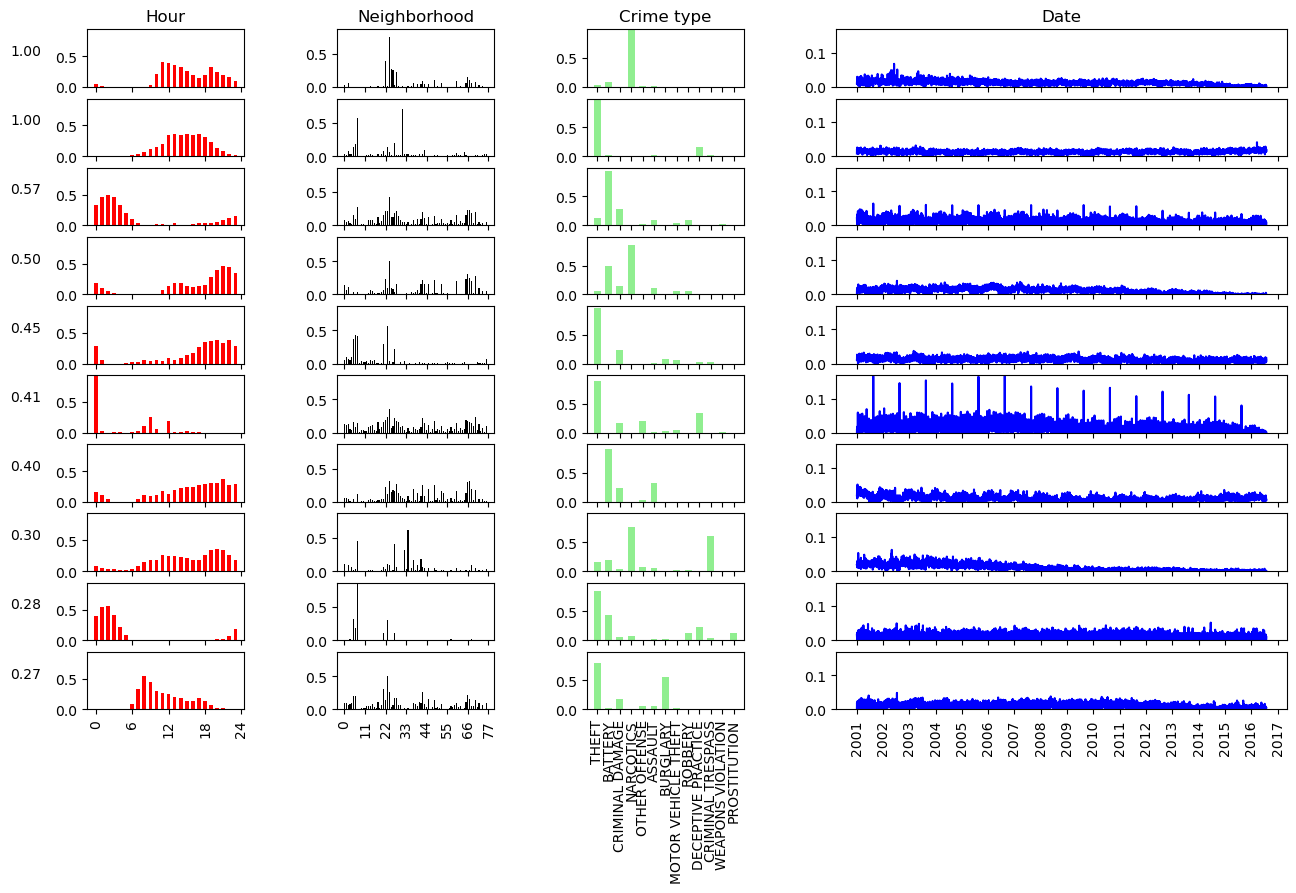

In [10]:
#u_static_gcp.extract([0,1,2,3,4])
fig, axs = u_static_gcp_extracted.vis(show_figure=False, plots=plots, rel_widths=[7,7,7,20], horz_space=0.4,right_space=1, left_space=0.2, bot_space=0.2, mode_titles=["Hour", "Neighborhood", "Crime type", "Date"])
fig.set_size_inches(15,10)
fig.savefig("chicago_crime_vis_poisson.jpg", dpi=300)


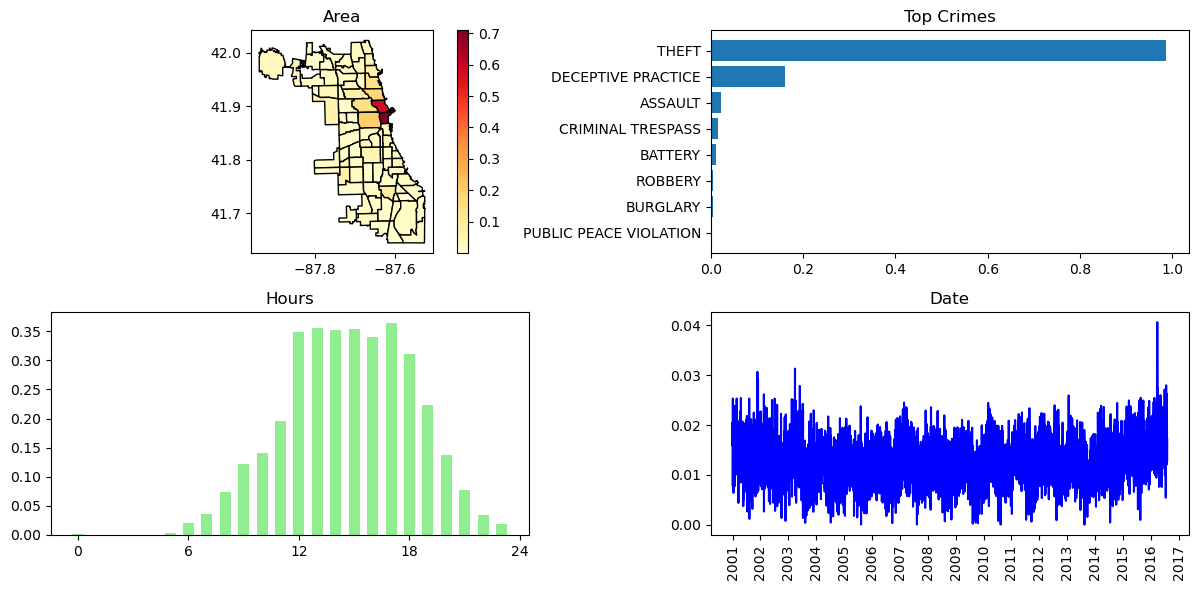

In [11]:
def plot_generalization(u_static_gcp, n):
    # Extract the components from the tensor
    #u_static_gcp_extracted = u_static_gcp.extract([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    # Get the factor matrice of components
    #u_static_gcp_hours = u_static_gcp_extracted.factor_matrices[0]
    #u_static_gcp_hours = np.array(u_static_gcp_hours)           

    #u_static_gcp_neighborhood = u_static_gcp_extracted.factor_matrices[1]
    #u_static_gcp_neighborhood = np.array(u_static_gcp_neighborhood)             

    #u_static_gcp_crime_type = u_static_gcp_extracted.factor_matrices[2]
    #u_static_gcp_crime_type = np.array(u_static_gcp_crime_type)           

    #u_static_gcp_day = u_static_gcp_extracted.factor_matrices[3]
    #u_static_gcp_day = np.array(u_static_gcp_day)               

    # Get the year from the mode-1 .map file and the indices
    indices_content, year_content = read_map_file_to_array('mode-1-date.map')

    # Get the crime types from mode-4 .map file
    map_content, crimes = read_map_file_to_array('mode-4-crimetype.map')

    # Find the top crimes with the highest value
    highest_values_crime_bis = u_static_gcp_crime_type[:,n] # Get the first column of the crime factor matrix
    highest_values_crime_indices = np.argsort(highest_values_crime_bis) # Sort the list of indices in ascending order based on their corresponding values

    highest_values_crime_sliced_indices = highest_values_crime_indices[24:] # Slice the initial list of indices to create a new list with only the last eight indices
    
    top_crimes_list = []  # List that will contain the top crimes # Labels

    # Create a list of top crimes
    for i in range(len(highest_values_crime_sliced_indices)):
        for j in range(len(crimes)):
            if highest_values_crime_sliced_indices[i] == j:
                top_crimes_list.append(crimes[j])
                
    top_crime_values_list = []   # List that will contain the values of the top crimes

    # Find the values of top crimes in highest_values_crime_bis
    for i in range(len(highest_values_crime_sliced_indices)):
        for j in range(len(highest_values_crime_bis)):
            # find the value of the crimes in highest_values_crime_bis based on the index in highest_values_crime_sliced_indices
            if highest_values_crime_sliced_indices[i] == j:
                top_crime_values_list.append(highest_values_crime_bis[j])

    hours = u_static_gcp_hours[:,n] # Get the first column of 'u_static_gcp_hours' factor matrix
    days = u_static_gcp_day[:,n] # Get the first column of 'u_static_gcp_hours' factor matrix
    indices_gcp_content = indices_content # List containing the indices of the year
    year_gcp_content = year_content # List containing the year

    neighborhood_values = u_static_gcp_neighborhood[:,n] # Get the first column of neighborhood form 'u_static_gcp_neighborhood' factor matrix
    file_name = gpd.read_file('Chicago_Boundaries_Community_Areas.geojson') # Read the file of Chicago boundaries areas
    neighborhoods_name = file_name
    neighborhoods_name['Neighborhood values'] = neighborhood_values # Create a new column 'Neighborhood values' that contains chicago's neighborhood values from the factor matrix 'u_static_gcp_neighborhood'

    # Plot the figures
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    neighborhoods_name.plot(column = 'Neighborhood values',edgecolor = 'black',linewidth = 1.0, cmap = 'YlOrRd', legend = True, ax=axs[0, 0])
    axs[0, 0].set_title("Area")

    axs[0, 1].barh(list(range(len(highest_values_crime_bis[highest_values_crime_sliced_indices]))),top_crime_values_list)
    axs[0, 1].set_yticks(list(range(len(highest_values_crime_bis[highest_values_crime_sliced_indices]))), labels=top_crimes_list, rotation = 360)
    axs[0, 1].set_title("Top Crimes")

    axs[1, 0].bar(list(range(len( hours))), hours, color = 'lightgreen' , width = 0.6)
    axs[1, 0].set_xticks([0, 6, 12, 18, 24], labels=["0", "6", "12", "18", "24"], rotation=360)
    axs[1, 0].set_title("Hours")

    axs[1, 1].plot(list(range(len(days))), days, color = 'blue')
    axs[1, 1].set_xticks(indices_gcp_content, labels= year_gcp_content, rotation = 90)
    axs[1,1 ].set_title("Date")
    
    plt.tight_layout()
    plt.savefig("chicago_crime_firstcomp_poisson.jpg")
    plt.show()


plot_generalization(u_static_gcp, 1)